Imports


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import glob as gb
import tensorflow as tf
import matplotlib.image as mpimg
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from  matplotlib import pyplot as plt
from keras import models 
from keras import layers
from scipy import fftpack

from skimage import io, color
from skimage.color import rgb2gray
from skimage.io import imread
from PIL import Image as im
from PIL import ImageFile

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
def create_data_frame_for_folder_mean_red_and_green_rgb_images(filepath,label):
  list_of_green_mean_intensities=[]
  list_of_red_mean_intensities=[]
  df = pd.DataFrame()
  files = gb.glob(pathname= str(filepath+'/*.png'))
  for file in files:
      image = cv2.imread(file)
      b,g,r = cv2.split(image)
      
      list_of_green_mean_intensities.append(np.mean(g))
      list_of_red_mean_intensities.append(np.mean(r))
  labels_list=[label]*len(list_of_green_mean_intensities)
  df['Mean intensity of green']=list_of_green_mean_intensities
  df['Mean intensity of red']=list_of_red_mean_intensities

  df['Aniematic']=labels_list
  return df



Helper functions

In [ ]:
#CieLAB images functions

#Check if pixel is white
def IsWhite(pixel):
  white=255
  white_counter=0
  is_white=False
  for i in range(0,3):
    if(pixel[i]==white):
      white_counter=white_counter+1
  if(white_counter==3):
    is_white=True
  return(is_white)
#to reach cielab you must go from rgb to xyz
#these conversions are from a website
def convert_from_rgb_to_xyz(pixel):
  var_R = ( pixel[0] / 255 )
  var_G = ( pixel[1] / 255 )
  var_B = ( pixel[2] / 255 )

  if ( var_R > 0.04045 ):
    var_R = ( ( var_R + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_R = var_R / 12.92
  if ( var_G > 0.04045 ):
    var_G = ( ( var_G + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_G = var_G / 12.92
  if ( var_B > 0.04045 ):
    var_B = ( ( var_B + 0.055 ) / 1.055 )** 2.4
  else:
    var_B = var_B / 12.92

  var_R = var_R * 100
  var_G = var_G * 100
  var_B = var_B * 100

  X = var_R * 0.4124 + var_G * 0.3576 + var_B * 0.1805
  Y = var_R * 0.2126 + var_G * 0.7152 + var_B * 0.0722
  Z = var_R * 0.0193 + var_G * 0.1192 + var_B * 0.9505
  return [X,Y,Z]

def convert_from_xyz_to_lab(xyz_pixel):
  #these constants are from skimage documentation 
  X=95.047
  Y=100.000
  Z=108.883
  var_X = xyz_pixel[0] / X
  var_Y = xyz_pixel[1] / Y
  var_Z = xyz_pixel[2] / Z

  if ( var_X > 0.008856 ):
     var_X = var_X** ( 1/3 )
  else:
     var_X = ( 7.787 * var_X ) + ( 16 / 116 )
  if ( var_Y > 0.008856 ):
     var_Y = var_Y ** ( 1/3 )
  else:
     var_Y = ( 7.787 * var_Y ) + ( 16 / 116 )
  if ( var_Z > 0.008856 ):
     var_Z = var_Z ** ( 1/3 )
  else :
     var_Z = ( 7.787 * var_Z ) + ( 16 / 116 )

  l = ( 116 * var_Y ) - 16
  a = 500 * ( var_X - var_Y )
  b = 200 * ( var_Y - var_Z )
  return l,a,b


In [ ]:
def create_data_frame_with_mean_of_red_and_green(folder_path,label):
  list_of_red_components=[]
  list_of_green_components=[]
  list_of_means_of_green=[]
  list_of_means_of_red=[]
  df = pd.DataFrame()
  #read image
  #edit to fit png 
  files = gb.glob(pathname= str(folder_path+'/*.png'))
  for file in files:
    image = io.imread(file)
    image_height=image.shape[0]
    image_width=image.shape[1]
    list_of_new_image_pixels=[]
    #choose non white pixels in the image
    for h in range(0,image_height):
      for w in range(0,image_width):
        if(IsWhite(image[h][w])==False):
          list_of_new_image_pixels.append(image[h][w])

    list_of_a_values=[]
    #convert pixel list from rgb to cielab
    #convertion is done pixel by pixel
    for i in range (0,len(list_of_new_image_pixels)):
      converted_to_xyz_pixel=convert_from_rgb_to_xyz(list_of_new_image_pixels[i])
      l,a,b=convert_from_xyz_to_lab(converted_to_xyz_pixel)
      list_of_a_values.append(a)
    #caluclate red and green components for a list 
    for i in range (0,len(list_of_a_values)):
        if(list_of_a_values[i]>0):
          list_of_red_components.append(list_of_a_values[i])
        elif(list_of_a_values[i]<0):
          list_of_green_components.append(list_of_a_values[i])
    list_of_means_of_green.append(np.mean(list_of_green_components))
    list_of_means_of_red.append(np.mean(list_of_red_components))
    

  labels_list=[label]*len(list_of_means_of_green)
  df['Mean intensity of green']=list_of_means_of_green
  df['Mean intensity of red']=pd.Series(list_of_means_of_red)

  df['Aniematic']=labels_list
  return df

In [ ]:
#function to extract median of channels to add it as a feature
def extract_median(folder_path,label):
  files = gb.glob(pathname= str(folder_path+'/*.jpg'))
  list_of_g_medians=[]
  list_of_r_medians=[]
  df = pd.DataFrame()

  for file in files:
        image = cv2.imread(file)
        b, g, r = cv2.split(image) # Split channels
        # Remove zeros
        g = g[g != 0]
        r = r[r != 0]
        g=g[g != 255]
        r=r[r != 255]
        # median values
        r_median = np.median(r)
        g_median = np.median(g)
        list_of_g_medians.append(g_median)
        list_of_r_medians.append(r_median)
  df['Median of green']=list_of_g_medians
  df['Median of red']=list_of_r_medians

  return df




Reading data from saved csv

In [ ]:
data_cielab_fp=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_forniceal_palpebral2.csv")
data_cielab_p=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_palpebral2.csv")
data_cielab_f=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_forniceal2.csv")
#data_rgb_fp=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_palpebral_rgb.csv")
#data_rgb_p=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_palpebral_rgb.csv")
#data_rgb_f=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_rgb.csv")
data_rgb_fp=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_palpebralnew.csv")
data_rgb_p=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/datasetpalpebralnew.csv")
data_rgb_f=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_fornicealnew.csv")

In [ ]:
#data_rgb_fp['Median of green']= med_g_fp
data_rgb_fp.insert(loc=3,column='Median of green',value=med_g_fp)
data_rgb_fp.insert(loc=4,column='Median of red',value=med_r_fp)
data_rgb_f.insert(loc=3,column='Median of green',value=med_g_f)
data_rgb_f.insert(loc=4,column='Median of red',value=med_r_f)
data_rgb_p.insert(loc=3,column='Median of green',value=med_g_p)
data_rgb_p.insert(loc=4,column='Median of red',value=med_r_p)
#data_rgb_fp['Median of red']= med_r_fp
#data_rgb_f['Median of green']= med_g_f
#data_rgb_f['Median of red']= med_r_f
#data_rgb_p['Median of green']= med_g_p
#data_rgb_p['Median of red']= med_r_p

In [ ]:
data_rgb_fp

,Unnamed: 0,Mean intensity of green,Mean intensity of red,Median of green,Median of red,Aniematic
0,0,236.261997,244.383783,125.0,187.0,1
1,1,244.622951,249.548226,117.0,187.0,1
2,2,234.204748,244.377635,134.0,191.0,1
3,3,238.641478,245.723182,118.0,181.0,1
4,4,239.287858,246.292678,146.0,194.0,1
...,...,...,...,...,...,...
205,107,231.710136,239.971426,84.0,176.0,0
206,108,228.860588,238.967721,74.0,148.0,0
207,109,238.240257,244.644643,78.0,152.0,0
208,110,240.891584,246.833267,92.0,178.0,0


In [ ]:
features=['Mean intensity of green','Mean intensity of red']
features_rgb=['Median of green','Median of red']

In [ ]:
data_cielab_fp

,Unnamed: 0,Mean intensity of green,Mean intensity of red,Aniematic
0,0,-0.863192,21.565868,1
1,1,-0.889914,22.971307,1
2,2,-0.993238,24.757966,1
3,3,-1.033498,24.787154,1
4,4,-1.002398,24.618989,1
...,...,...,...,...
205,107,-0.775627,32.448125,0
206,108,-0.774660,32.448239,0
207,109,-0.774592,32.437953,0
208,110,-0.774457,32.414778,0


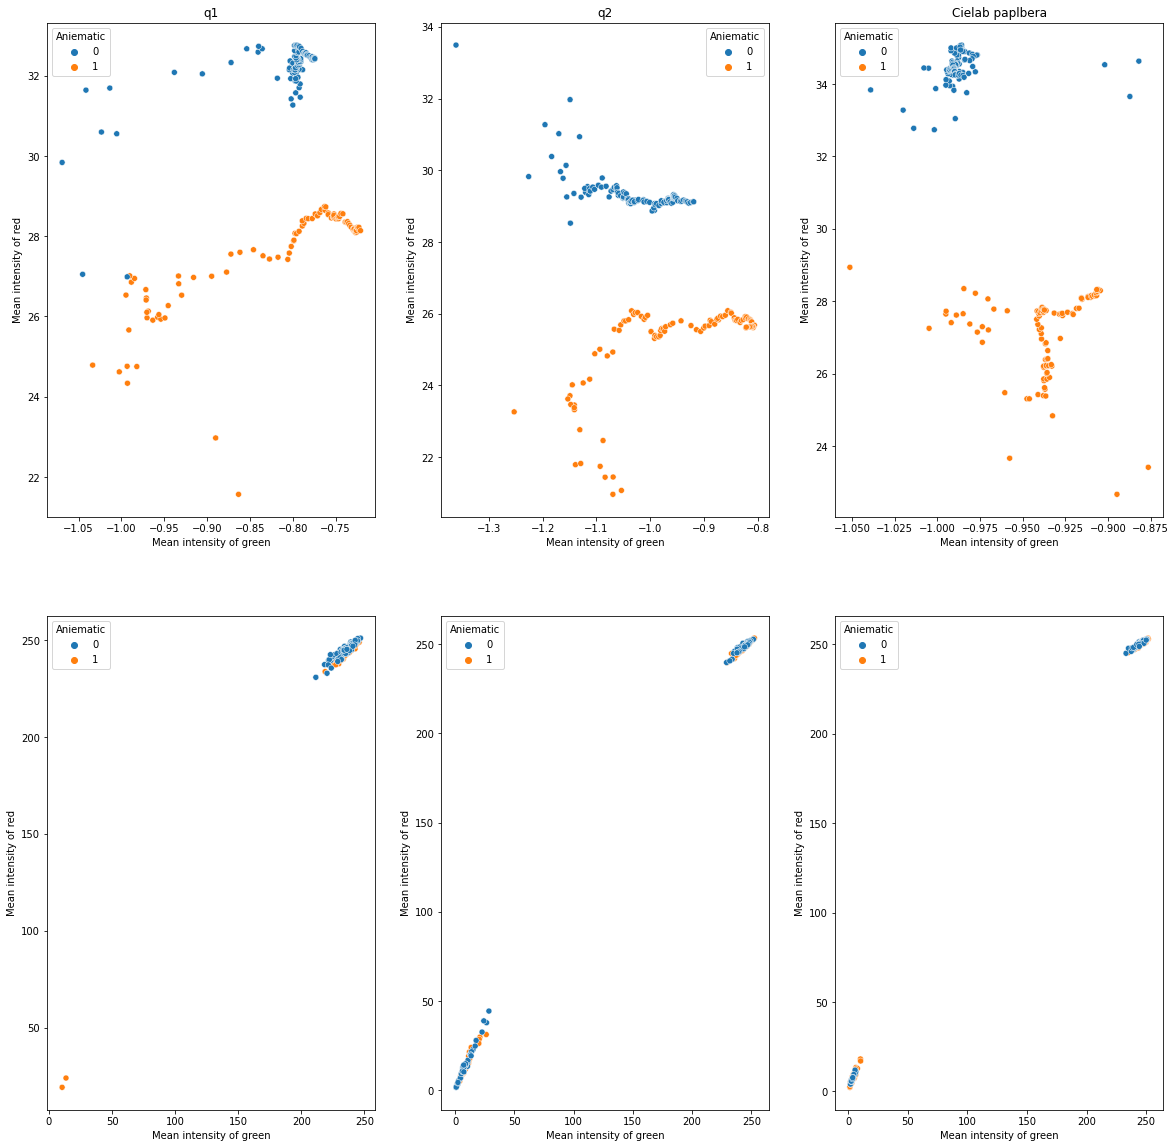

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
# reading the database
fig, axs = plt.subplots(2,3,figsize=(20, 20))

axs[0,0].set_title('q1')
axs[0,1].set_title('q2')
axs[0,2].set_title('Cielab paplbera')

sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_fp,hue='Aniematic',ax=axs[0,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_f,hue='Aniematic',ax=axs[0,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_p,hue='Aniematic',ax=axs[0,2])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_fp,hue='Aniematic',ax=axs[1,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_f,hue='Aniematic',ax=axs[1,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_p,hue='Aniematic',ax=axs[1,2])
plt.show()

Making dataset variables , splitting data to train and test

In [ ]:
x_cielab_fp=data_cielab_fp[features]
y_cielab_fp=data_cielab_fp.iloc[:,-1:]
y_cielab_fp=y_cielab_fp.values.ravel()

x_cielab_f=data_cielab_f[features]
y_cielab_f=data_cielab_f.iloc[:,-1:]
y_cielab_f=y_cielab_f.values.ravel()

x_cielab_p=data_cielab_p[features]
y_cielab_p=data_cielab_p.iloc[:,-1:]
y_cielab_p=y_cielab_p.values.ravel()

x_rgb_fp=data_rgb_fp[features]
y_rgb_fp=data_rgb_fp.iloc[:,-1:]
y_rgb_fp=y_rgb_fp.values.ravel()

x_rgb_f=data_rgb_f[features]
y_rgb_f=data_rgb_f.iloc[:,-1:]
y_rgb_f=y_rgb_f.values.ravel()

x_rgb_p=data_rgb_p[features]
y_rgb_p=data_rgb_p.iloc[:,-1:]
y_rgb_p=y_rgb_p.values.ravel()



x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp=train_test_split(x_cielab_fp,y_cielab_fp,test_size=0.3,random_state=0)
x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f=train_test_split(x_cielab_f,y_cielab_f,test_size=0.3,random_state=0)
x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p=train_test_split(x_cielab_p,y_cielab_p,test_size=0.3,random_state=0)
x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp=train_test_split(x_rgb_fp,y_rgb_fp,test_size=0.3,random_state=0)
x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f=train_test_split(x_rgb_f,y_rgb_f,test_size=0.3,random_state=0)
x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p=train_test_split(x_rgb_p,y_rgb_p,test_size=0.3,random_state=0)


Getting hyper parameters for log reg

In [ ]:
from sklearn.model_selection import GridSearchCV

param_log = {'C': np.logspace(-12, 12, num=22),'penalty' : ['l2']}

log_model=LogisticRegression() 
def logreg_hyper_parameters(x_train,y_train):
  log_gscv = GridSearchCV(log_model, param_log)
  log_gscv.fit(x_train, y_train)
  log_best_parameters=log_gscv.best_params_
  C_log=log_best_parameters['C']
  penalty_log=log_best_parameters['penalty']
  return(C_log,penalty_log)


C_log_cielab_fp,penalty_log_cielab_fp=logreg_hyper_parameters(x_train_cielab_fp, y_train_cielab_fp)
C_log_cielab_f,penalty_log_cielab_f=logreg_hyper_parameters(x_train_cielab_f, y_train_cielab_f)
C_log_cielab_p,penalty_log_cielab_p=logreg_hyper_parameters(x_train_cielab_p, y_train_cielab_p)

C_log_rgb_fp,penalty_log_rgb_fp=logreg_hyper_parameters(x_train_rgb_fp, y_train_rgb_fp)
C_log_rgb_f,penalty_log_rgb_f=logreg_hyper_parameters(x_train_rgb_f, y_train_rgb_f)
C_log_rgb_p,penalty_log_rgb_p=logreg_hyper_parameters(x_train_rgb_p, y_train_rgb_p)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training , testing and scoring of log reg

In [ ]:
def logreg_training_testing_scoring(c,penalty,x_train,x_test,y_train,y_test):
  logreg = LogisticRegression(C=  c,penalty= penalty)
  logreg.fit(x_train,y_train)
  log_train=logreg.score(x_train,y_train)
  log_test=logreg.score(x_test,y_test)
  print("log train score is:",log_train,"log test is",log_test)
  return logreg

logreg_cielab_fp = logreg_training_testing_scoring(C_log_cielab_fp,penalty_log_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
logreg_cielab_f = logreg_training_testing_scoring(C_log_cielab_f,penalty_log_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
logreg_cielab_p = logreg_training_testing_scoring(C_log_cielab_p,penalty_log_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

logreg_rgb_fp = logreg_training_testing_scoring(C_log_rgb_fp,penalty_log_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
logreg_rgb_f = logreg_training_testing_scoring(C_log_rgb_f,penalty_log_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
logreg_rgb_p = logreg_training_testing_scoring(C_log_rgb_p,penalty_log_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

log train score is: 0.9931972789115646 log test is 1.0
log train score is: 1.0 log test is 1.0
log train score is: 1.0 log test is 1.0
log train score is: 0.7891156462585034 log test is 0.7619047619047619
log train score is: 0.6081081081081081 log test is 0.5625
log train score is: 0.7350993377483444 log test is 0.7384615384615385


Plotting decision boundaries

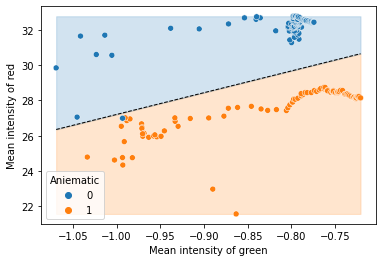

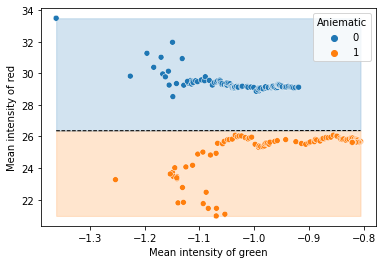

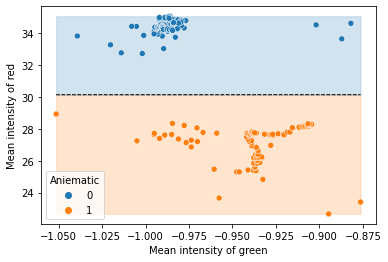

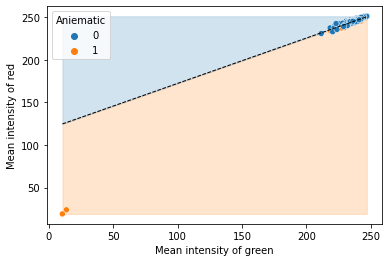

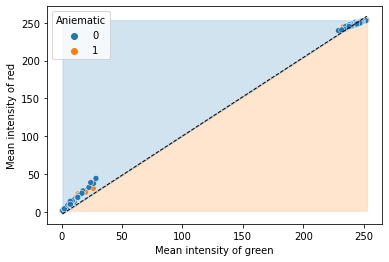

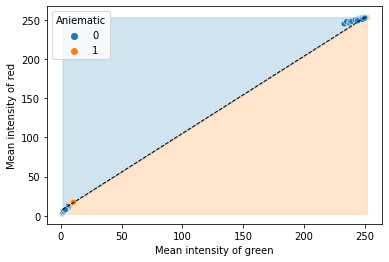

In [ ]:
def plot_log_model_decision_boundary(clf,data):
  b = clf.intercept_[0]
  w1, w2 = clf.coef_.T
  # Calculate the intercept and gradient of the decision boundary.
  c = -b/w2
  m = -w1/w2

  # Plot the data and the classification with the decision boundary.
  xmin = min(data['Mean intensity of green'])
  xmax=max(data['Mean intensity of green'])
  ymin = min(data['Mean intensity of red'])
  ymax=max(data['Mean intensity of red'])
  xd = np.array([xmin, xmax])
  yd = m*xd + c
  plt.plot(xd, yd, 'k', lw=1, ls='--')
  plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
  plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2) 
  sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data,
                hue='Aniematic')
  plt.show()
plot_log_model_decision_boundary(logreg_cielab_fp,data_cielab_fp)
plot_log_model_decision_boundary(logreg_cielab_f,data_cielab_f)
plot_log_model_decision_boundary(logreg_cielab_p,data_cielab_p)
plot_log_model_decision_boundary(logreg_rgb_fp,data_rgb_fp)
plot_log_model_decision_boundary(logreg_rgb_f,data_rgb_f)
plot_log_model_decision_boundary(logreg_rgb_p,data_rgb_p)


In [ ]:
'''
#cross validation
from sklearn.model_selection import cross_val_score
clf = logreg
scores = cross_val_score(clf, x_cielab_fp, y_cielab_fp, cv=10)
scores
'''

Hyperparameters of SVM

In [ ]:
param_svm = {'kernel' : ('poly', 'rbf'), 'C':[0.01, 0.1, 0.5, 1, 10]}
svm_model=svm.SVC() 
def svm_hyper_parameters(x_train,y_train):
  svm_gscv = GridSearchCV(svm_model, param_svm)
  svm_gscv.fit(x_train, y_train)
  svm_best_parameters=svm_gscv.best_params_
  C_svm=svm_best_parameters['C']
  kernel_svm=svm_best_parameters['kernel']
  return(C_svm,kernel_svm)

C_svm_cielab_fp,kernel_svm_cielab_fp=svm_hyper_parameters(x_train_cielab_fp, y_train_cielab_fp)
C_svm_cielab_f,kernel_svm_cielab_f=svm_hyper_parameters(x_train_cielab_f, y_train_cielab_f)
C_svm_cielab_p,kernel_svm_cielab_p=svm_hyper_parameters(x_train_cielab_p, y_train_cielab_p)

C_svm_rgb_fp,kernel_svm_rgb_fp=svm_hyper_parameters(x_train_rgb_fp, y_train_rgb_fp)
C_svm_rgb_f,kernel_svm_rgb_f=svm_hyper_parameters(x_train_rgb_f, y_train_rgb_f)
C_svm_rgb_p,kernel_svm_rgb_p=svm_hyper_parameters(x_train_rgb_p, y_train_rgb_p)

Training , resting and scoring of SVM

In [ ]:
def svm_training_testing_scoring(c,kernel,x_train,x_test,y_train,y_test):
  svm_clf = svm.SVC(C=  c,kernel= kernel)
  svm_clf.fit(x_train,y_train)
  svm_train=svm_clf.score(x_train,y_train)
  svm_test=svm_clf.score(x_test,y_test)
  print("svm train score is:",svm_train,"svm test is",svm_test)
  return svm_clf


svm_cielab_fp = svm_training_testing_scoring(C_svm_cielab_fp,kernel_svm_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
svm_cielab_f = svm_training_testing_scoring(C_svm_cielab_f,kernel_svm_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
svm_cielab_p = svm_training_testing_scoring(C_svm_cielab_p,kernel_svm_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

svm_rgb_fp = svm_training_testing_scoring(C_svm_rgb_fp, kernel_svm_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
svm_rgb_f = svm_training_testing_scoring(C_svm_rgb_f,kernel_svm_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
svm_rgb_p = svm_training_testing_scoring(C_svm_rgb_p,kernel_svm_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

svm train score is: 0.9863945578231292 svm test is 1.0
svm train score is: 1.0 svm test is 1.0
svm train score is: 1.0 svm test is 1.0
svm train score is: 0.8027210884353742 svm test is 0.7619047619047619
svm train score is: 0.5945945945945946 svm test is 0.5625
svm train score is: 0.695364238410596 svm test is 0.5846153846153846


Hyperparameters of decision trees

In [ ]:
param_tree={'criterion':('gini', 'entropy'),'max_depth':[2,4,6,8,10,12]}
tree_model=DecisionTreeClassifier() 

def tree_hyper_parameters(x_train,y_train):
  tree_gscv= GridSearchCV(tree_model, param_tree)
  tree_gscv.fit(x_train, y_train)
  tree_best_parameters=tree_gscv.best_params_
  max_depth=tree_best_parameters['max_depth']
  criterion=tree_best_parameters['criterion']
  return(max_depth,criterion)



max_depth_cielab_fp,criterion_cielab_fp=tree_hyper_parameters(x_train_cielab_fp,y_train_cielab_fp)
max_depth_cielab_f,criterion_cielab_f=tree_hyper_parameters(x_train_cielab_f,y_train_cielab_f)
max_depth_cielab_p,criterion_cielab_p=tree_hyper_parameters(x_train_cielab_p,y_train_cielab_p)

max_depth_rgb_fp,criterion_rgb_fp=tree_hyper_parameters(x_train_rgb_fp,y_train_rgb_fp)
max_depth_rgb_f,criterion_rgb_f=tree_hyper_parameters(x_train_rgb_f,y_train_rgb_f)
max_depth_rgb_p,criterion_rgb_p=tree_hyper_parameters(x_train_rgb_p,y_train_rgb_p)

Training,testing and scoring of decision tress

In [ ]:
def tree_training_testing_scoring(criterion,max_depth,x_train,x_test,y_train,y_test):
  clf_tree = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
  clf_tree.fit(x_train, y_train)
  tree_train=clf_tree.score(x_train, y_train)
  tree_test=clf_tree.score(x_test, y_test)
  print("tree train score is:",tree_train,"tree test is",tree_test)
  return clf_tree


clf_tree_cielab_fp = tree_training_testing_scoring(criterion_cielab_fp,max_depth_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
clf_tree_cielab_f = tree_training_testing_scoring(criterion_cielab_f,max_depth_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
clf_tree_cielab_p = tree_training_testing_scoring(criterion_cielab_p,max_depth_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

clf_tree_rgb_fp = tree_training_testing_scoring(criterion_rgb_fp,max_depth_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
clf_tree_rgb_f = tree_training_testing_scoring(criterion_rgb_f,max_depth_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
clf_tree_rgb_p = tree_training_testing_scoring(criterion_rgb_p,max_depth_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)


tree train score is: 1.0 tree test is 0.9841269841269841
tree train score is: 1.0 tree test is 1.0
tree train score is: 1.0 tree test is 1.0
tree train score is: 0.8843537414965986 tree test is 0.6666666666666666
tree train score is: 0.75 tree test is 0.609375
tree train score is: 1.0 tree test is 0.6615384615384615


Training ,testing and scoring of naive bayes

In [ ]:
def nb_training_testing_scoring(x_train,x_test,y_train,y_test):
  gauss_model= GaussianNB()
  gauss_model.fit(x_train, y_train)
  nb_train=gauss_model.score(x_train, y_train)
  nb_test=gauss_model.score(x_test, y_test)
  print("nb train score is:",nb_train,"nb test is",nb_test)
  return gauss_model
gauss_model_cielab_fp=nb_training_testing_scoring(x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
gauss_model_cielab_f = nb_training_testing_scoring(x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
gauss_model_cielab_p = nb_training_testing_scoring(x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)
gauss_model_rgb_fp = nb_training_testing_scoring(x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
gauss_model_rgb_f = nb_training_testing_scoring(x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
gauss_model_rgb_p = nb_training_testing_scoring(x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

nb train score is: 0.9727891156462585 nb test is 0.9841269841269841
nb train score is: 1.0 nb test is 1.0
nb train score is: 1.0 nb test is 1.0
nb train score is: 0.5238095238095238 nb test is 0.5238095238095238
nb train score is: 0.5608108108108109 nb test is 0.59375
nb train score is: 0.695364238410596 nb test is 0.5846153846153846


Hyperparameters of knn

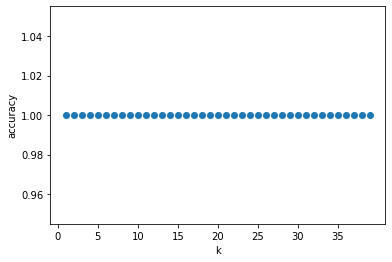

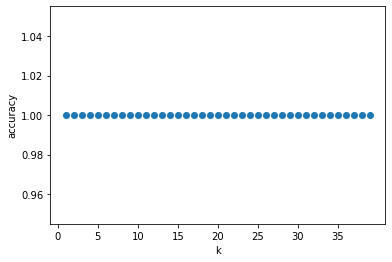

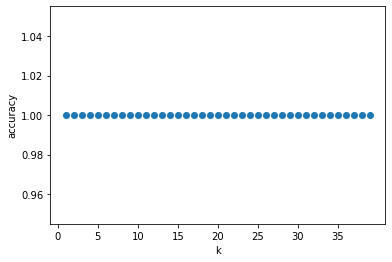

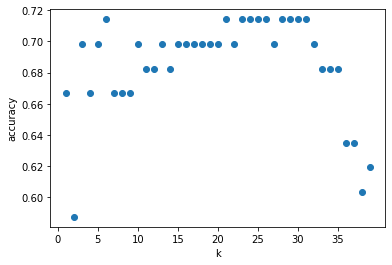

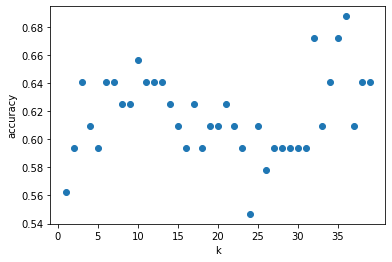

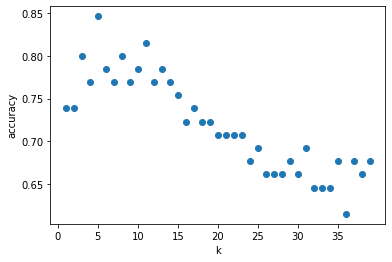

In [ ]:
#Visualization
#to choose best k for knn
import matplotlib.pyplot as plt
%matplotlib inline
def visualization_for_kmeans(x_train,x_test,y_train,y_test):
  k_range = range(1,40)
  scores = []

  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(x_train, y_train)
      scores.append(knn.score(x_test, y_test))
  max_score=max(scores)
  k_number=scores.index(max_score)+1

  plt.figure()
  plt.xlabel('k')
  plt.ylabel('accuracy')
  plt.scatter(k_range, scores)
  plt.xticks([0,5,10,15,20,25,30,35]);
  return k_number

k_number_cielab_fp=visualization_for_kmeans(x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
k_number_cielab_f=visualization_for_kmeans(x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
k_number_cielab_p=visualization_for_kmeans(x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)
k_number_rgb_fp=visualization_for_kmeans(x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
k_number_rgb_f=visualization_for_kmeans(x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
k_number_rgb_p=visualization_for_kmeans(x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)


Training,testing and scoring of knn

In [ ]:
def knn_model_training_testing_scoring(k_number,x_train,x_test,y_train,y_test):
  knn = KNeighborsClassifier(n_neighbors=k_number)
  #training
  knn.fit(x_train, y_train)
  #scores
  #training
  knn_train=knn.score(x_train, y_train)
  #testing
  knn_test=knn.score(x_test, y_test)
  print("knn train score is:",knn_train,"knn test score is",knn_test)
  return knn

knn_model_cielab_fp=knn_model_training_testing_scoring(k_number_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
knn_model_cielab_f=knn_model_training_testing_scoring(k_number_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
knn_model_cielab_p=knn_model_training_testing_scoring(k_number_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)
knn_model_rgb_fp=knn_model_training_testing_scoring(k_number_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
knn_model_rgb_f=knn_model_training_testing_scoring(k_number_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
knn_model_rgb_p=knn_model_training_testing_scoring(k_number_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

knn train score is: 1.0 knn test score is 1.0
knn train score is: 1.0 knn test score is 1.0
knn train score is: 1.0 knn test score is 1.0
knn train score is: 0.7891156462585034 knn test score is 0.7142857142857143
knn train score is: 0.6148648648648649 knn test score is 0.6875
knn train score is: 0.8278145695364238 knn test score is 0.8461538461538461


Model scores

In [ ]:
models_cielab_fp = []
models_cielab_fp.append(('Cielab fp Logistic Regression:',logreg_cielab_fp))
models_cielab_fp.append(('Cielab fp SVM                :', svm_cielab_fp))
models_cielab_fp.append(('Cielab fp Decision Tree      :', clf_tree_cielab_fp))
models_cielab_fp.append(('Cielab fp Naive Bayes        :',gauss_model_cielab_fp))
models_cielab_fp.append(('Cielab fp KNN                :', knn_model_cielab_fp))

models_cielab_f = []
models_cielab_f.append(('Cielab f Logistic Regression:',logreg_cielab_f))
models_cielab_f.append(('Cielab f SVM                :', svm_cielab_f))
models_cielab_f.append(('Cielab f Decision Tree      :', clf_tree_cielab_f))
models_cielab_f.append(('Cielab f Naive Bayes        :',gauss_model_cielab_f))
models_cielab_f.append(('Cielab f KNN                :', knn_model_cielab_f))

models_cielab_p = []
models_cielab_p.append(('Cielab p Logistic Regression:',logreg_cielab_p))
models_cielab_p.append(('Cielab p SVM                :', svm_cielab_p))
models_cielab_p.append(('Cielab p Decision Tree      :', clf_tree_cielab_p))
models_cielab_p.append(('Cielab p Naive Bayes        :',gauss_model_cielab_p))
models_cielab_p.append(('Cielab p KNN                :', knn_model_cielab_p))

models_rgb_fp = []
models_rgb_fp.append(('rgb fp Logistic Regression:',logreg_rgb_fp))
models_rgb_fp.append(('rgb fp SVM                :', svm_rgb_fp))
models_rgb_fp.append(('rgb fp Decision Tree      :', clf_tree_rgb_fp))
models_rgb_fp.append(('rgb fp Naive Bayes        :',gauss_model_rgb_fp))
models_rgb_fp.append(('rgb fp KNN                :', knn_model_rgb_fp))

models_rgb_f = []
models_rgb_f.append(('rgb f Logistic Regression:',logreg_rgb_f))
models_rgb_f.append(('rgb f SVM                :', svm_rgb_f))
models_rgb_f.append(('rgb f Decision Tree      :', clf_tree_rgb_f))
models_rgb_f.append(('rgb f Naive Bayes        :',gauss_model_rgb_f))
models_rgb_f.append(('rgb f KNN                :', knn_model_rgb_f))

models_rgb_p = []
models_rgb_p.append(('rgb p Logistic Regression:',logreg_rgb_p))
models_rgb_p.append(('rgb p SVM                :', svm_rgb_p))
models_rgb_p.append(('rgb p Decision Tree      :', clf_tree_rgb_p))
models_rgb_p.append(('rgb p Naive Bayes        :',gauss_model_rgb_p))
models_rgb_p.append(('rgb p KNN                :', knn_model_rgb_p))
def print_model_metrics(model_list,x_train,x_test,y_train,y_test):
  for name, model in model_list:
      model.fit(x_train, y_train)
      pred = model.predict(x_test).astype(int)
      print(name,accuracy_score(y_test, pred))
      print('Precision: %.3f' % precision_score(y_test, pred))
      print('Recall: %.3f' % recall_score(y_test, pred))   	
      print('F1 Score: %.3f' % f1_score(y_test, pred))
      print(confusion_matrix(y_test, pred))
      print("____________________________________________________________________")
print_model_metrics(models_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
print_model_metrics(models_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
print_model_metrics(models_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)
print_model_metrics(models_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
print_model_metrics(models_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
print_model_metrics(models_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

Cielab fp Logistic Regression: 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab fp SVM                : 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab fp Decision Tree      : 0.9841269841269841
Precision: 1.000
Recall: 0.966
F1 Score: 0.982
[[34  0]
 [ 1 28]]
____________________________________________________________________
Cielab fp Naive Bayes        : 0.9841269841269841
Precision: 0.967
Recall: 1.000
F1 Score: 0.983
[[33  1]
 [ 0 29]]
____________________________________________________________________
Cielab fp KNN                : 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab f Logistic Regression: 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[33  0]
 [ 0 31]]
____________________

Saving model

In [ ]:
import pickle
filename = 'finalized_logreg_cielab_fp.sav'
pickle.dump(logreg_cielab_fp, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#send a (1,2)size array to teh below function in the place of x test
# ie.e an array contianing mr,mg
#result = loaded_model.predict(X_test)